# The Best Counties in North Carolina to Open a Small Business:
## Convenience Stores
### NAICS CODE: 44512

#### Our Goal
Use hiearchical clustering models to find a subset of counties that fit our criteria<br>
for opening a convenience store. Next, we will train a decision tree on that data, and run<br>
the model to find the best counties in North Carolina. Then, we will retrieve and analyze more<br>
data about the convenience stores in those counties.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler, normalize
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Decision Trees
from sklearn.tree import DecisionTreeClassifier, plot_tree

pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('full.csv',
                dtype={
                    'GeoFips': str,
                    'State': str,
                }, na_values=['(NA)'])
df.head()

,GeoFips,County,State,Population,Per Capital Income,naics,Small,Large,GeoFIPS,Description,Percent Change
0,01001,Autauga,01,56145.0,46814.0,45111/,0,0,1000,Personal consumption expenditures,-0.715158
1,01001,Autauga,01,56145.0,46814.0,45111/,0,0,1000,Goods,5.392869
2,01001,Autauga,01,56145.0,46814.0,45111/,0,0,1000,Durable goods,10.659807
3,01001,Autauga,01,56145.0,46814.0,45111/,0,0,1000,Motor vehicles and parts,9.171198
4,01001,Autauga,01,56145.0,46814.0,45111/,0,0,1000,Furnishings and durable household equipment,14.721752


<b>Please ignore the typo:</b><i> Per Capital</i> should be <i>Per Capita</i>

## Hierarchical Clustering

Here we are using hierarchical clustering, because we are trying to cluster data that<br>
is skewed, and our we are applying prior assumptions to our data.<br>
That assumption is that if there is a low establishment to population ratio that is lower than<br>
clusters with similar or lower per capita income, then we will mark that county as a possible <br>
opportunity market.

In [3]:
hier = df.loc[df['naics'] == '44512/']
hier = hier.set_index('GeoFips')
hier = hier[['Population', 'Per Capital Income', 'Small', 'Large']]

In [4]:
hier_n = normalize(hier)
hier_n = pd.DataFrame(hier_n, columns=hier.columns, index=hier.index)
Z =  linkage(hier_n, method='complete')

In [8]:
memb = fcluster(Z, 8, criterion='maxclust')
memb = pd.Series(memb, index=hier_n.index)

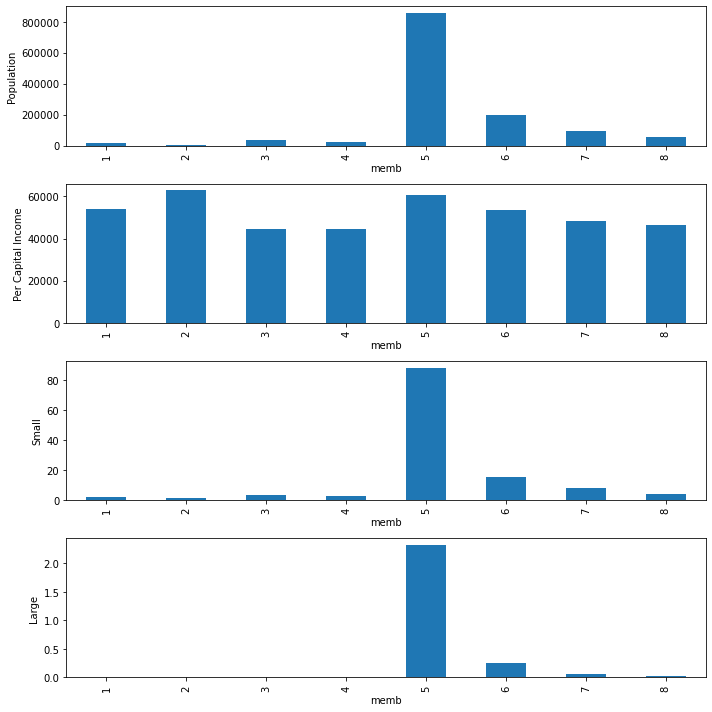

In [6]:
hier['memb'] = memb.values
fig, ax = plt.subplots(4, 1, figsize=(10,10))
for i, col in enumerate(hier.drop(columns='memb').columns):
    hier.groupby('memb')[col].mean().plot.bar(ax=ax[i])
    ax[i].set_ylabel(col)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='memb'>

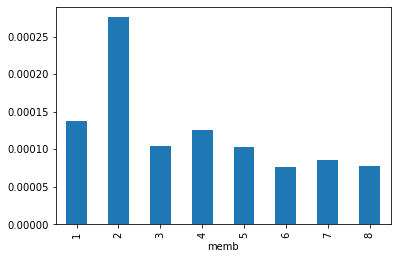

In [7]:
avg = hier.groupby('memb').mean()
avg['per'] = avg['Small'] / avg['Population']
avg['pl (thousands)'] = avg['Large'] / (avg['Population'] / 1000)
avg['per'].plot.bar()

<b>Group 6</b> has a very low establishment to population ratio, but average income of the groups.

In [10]:
hier['outcome'] = 'no'
hier['outcome'].loc[hier['memb'] == 6] = 'yes'

## Decision Tree
We have set group 6 as our desired outcome ('yes' open a convenience store).<br>
Then we will train the model on all the data except for counties in North Carolina.<br>
The resulting dataset will be the same as our original clusters, but I want to plot the<br>
the tree to see how it arrives at that decision.

In [12]:
train = hier.loc[hier.index.str[:2] != '37']
nc = hier.loc[hier.index.str[:2] == '37']
predictors = ['Population', 'Per Capital Income', 'Small', 'Large']
outcome = 'outcome'

X_train = train[predictors]
y_train = train[outcome]
X_nc = nc[predictors]

In [13]:
dtc = DecisionTreeClassifier(random_state=1, criterion='entropy',
                            min_impurity_decrease=0.003)
dtc.fit(X_train, y_train)
predict = X_nc.copy()
predict['outcome'] = dtc.predict(X_nc)
predict

,Population,Per Capital Income,Small,Large,outcome
GeoFips,,,,,
37001,171346.0,43973.0,7,0,yes
37001,171346.0,43973.0,7,0,yes
37001,171346.0,43973.0,7,0,yes
37001,171346.0,43973.0,7,0,yes
37001,171346.0,43973.0,7,0,yes
...,...,...,...,...,...
37197,37625.0,41250.0,3,0,no
37197,37625.0,41250.0,3,0,no
37197,37625.0,41250.0,3,0,no


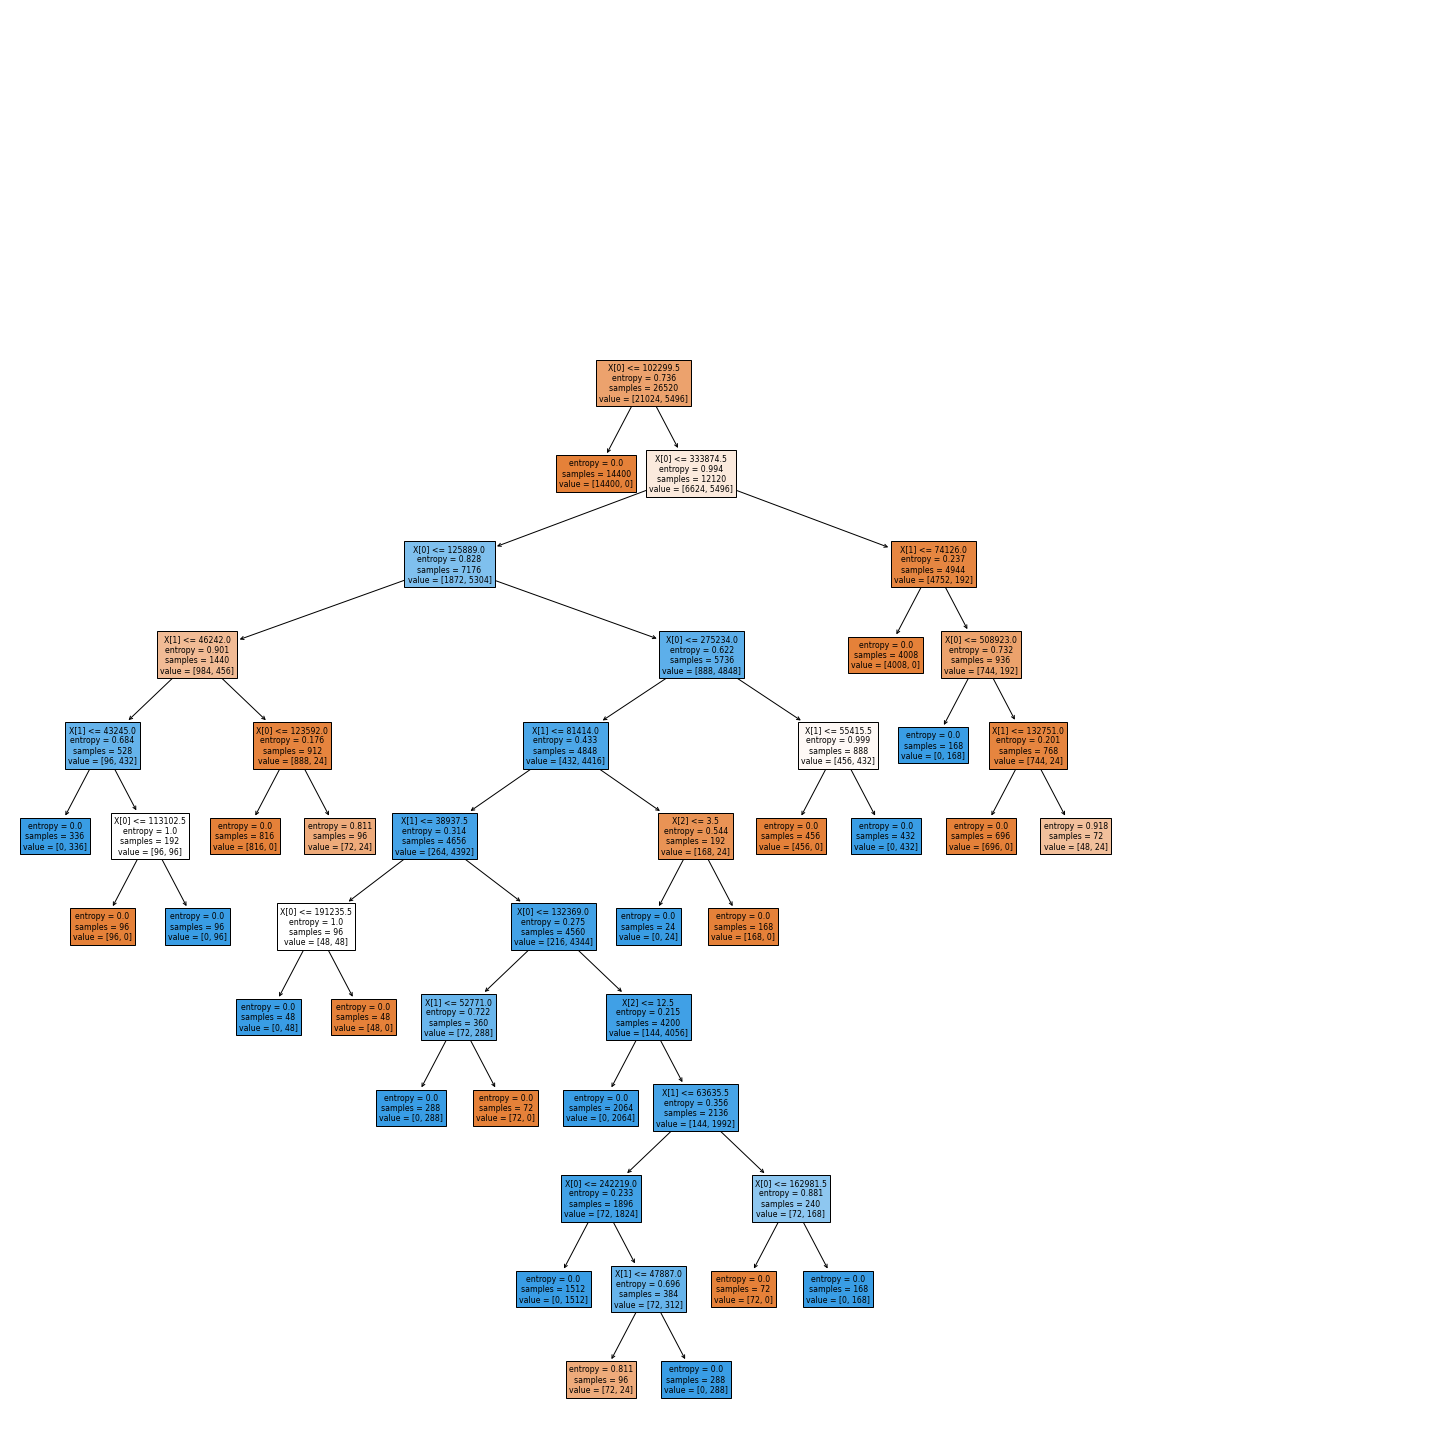

In [24]:
plt.figure(figsize=(20,20))
plot_tree(dtc, filled=True)
plt.tight_layout()
plt.show()

In [36]:
counties = predict.loc[predict['outcome'] == 'yes'].index.unique().to_list()
for county in counties:
    print(df.loc[df['GeoFips'] == county, 'County'].unique())

['Alamance']
['Brunswick']
['Buncombe']
['Cabarrus']
['Catawba']
['Davidson']
['Gaston']
['Harnett']
['Iredell']
['Johnston']
['New Hanover']
['Onslow']
['Orange']
['Pitt']
['Randolph']
['Robeson']
['Rowan']
['Union']
['Wayne']


## Data from NC Commerce Site
To retrieve the data, I scraped the information from the website using Selenium.<br>
You can find the code in the link below.<br>
https://github.com/vincentarcuri/data-analysis-projects/blob/main/New%20Markets%20for%20Small%20Business/NC%20Commerce%20Scraper.ipynb

In [37]:
df = pd.read_csv('convenience.csv')
df.head()

,Company Name,Street Address,City,State,Zip Code,Zip Plus,Contact First Name,Contact Last Name,Contact Title,Phone,...,NAICS2,NAICS3,NAICS4,NAICS5,Business Type,County,Employee,Annual Sales,URL,Year Established
0,Wildor Inc,728 N Church St,Burlington,NC,27217.0,2512.0,Ross,Wood,Site Manager,3362289506,...,NaN,NaN,NaN,NaN,Private,Alamance,9.0,2303000.0,GREAT-STOPS.COM,2007.0
1,Jays Mart,951 E Haggard Ave,Elon,NC,27244.0,9133.0,NaN,NaN,NaN,3365861900,...,NaN,NaN,NaN,NaN,Private,Alamance,3.0,768000.0,NaN,2012.0
2,Graham Mart,419 S Main St,Graham,NC,27253.0,3303.0,Rajesh,Adhikary,Owner,3363953604,...,NaN,NaN,NaN,NaN,Private,Alamance,1.0,256000.0,GAS-STATIONS.CITGO.COM,2016.0
3,Ganeesh Mart,1803 E Webb Ave,Burlington,NC,27217.0,7417.0,NaN,NaN,NaN,3362280839,...,NaN,NaN,NaN,NaN,Private,Alamance,2.0,512000.0,NaN,2011.0
4,Family Fare,2611 Maple Ave,Burlington,NC,27215.0,7194.0,Melody,Montgomery,Manager,3365709510,...,447190.0,447190.0,NaN,NaN,Private,Alamance,5.0,1280000.0,BP.COM,2002.0


#### Categorize by Chain Convenience Store

In [41]:
size = df.groupby('Company Name').size()
chains = size.loc[size > 4].index.to_list()

In [42]:
def isChain(row):
    if row['Company Name'] in chains:
        return True
    else:
        return False

In [43]:
df['chain'] = df.apply(isChain, axis=1)
df.loc[df['Company Name'] == 'Sheetz Inc', 'chain'] = True
df.loc[df['Company Name'] == 'Enmarket', 'chain'] = True
df.loc[df['Company Name'] == 'Roadrunner Market', 'chain'] = True
df.loc[df['Company Name'] == 'Quick Trip', 'chain'] = True

#### Comparing Chains vs Not

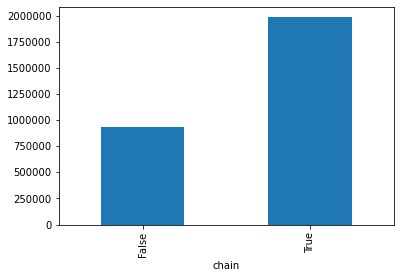

In [44]:
df.groupby('chain')['Annual Sales'].mean().plot.bar()
plt.ticklabel_format(axis='y', style='plain')

#### The Counties by Majority Chain or Not

In [45]:
percent_chain = df.groupby('County')['chain'].value_counts(normalize=True)
percent_chain.loc[percent_chain > .5]

County       chain
Alamance     False    0.536585
Brunswick    True     0.595238
Buncombe     False    0.703125
Cabarrus     True     0.618182
Davidson     False    0.540541
Gaston       False    0.527778
Harnett      True     0.567568
Iredell      True     0.565217
Johnston     True     0.540000
New Hanover  True     0.583333
Onslow       True     0.652174
Orange       False    0.571429
Pitt         True     0.593220
Randolph     True     0.555556
Robeson      False    0.879310
Rowan        False    0.612245
Union        True     0.545455
Wayne        False    0.542373
Name: chain, dtype: float64